# DBSCAN Debugging

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

agg = pd.read_csv('../data/outputs/agg_features.csv')

The following plot helps choose a good `eps` value by examining the distance to the 4th nearest neighbour.

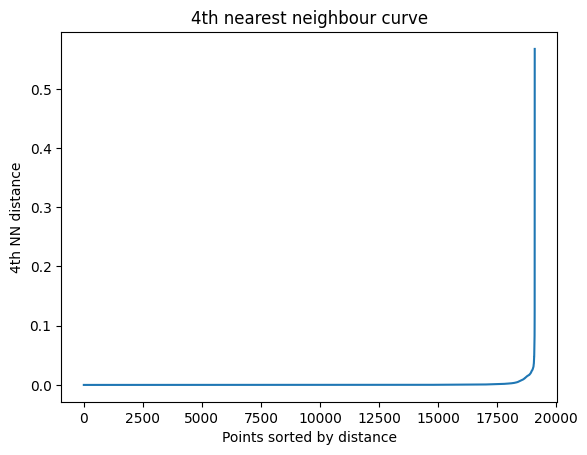

In [14]:
sim_cols = [c for c in agg.columns if c not in {'record_id','cluster'}]
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(agg[sim_cols])
# Distances to the 4th nearest neighbour for each point
dists, _ = neigh.kneighbors(agg[sim_cols])
fourth = dists[:, -1]
plt.plot(sorted(fourth))
plt.xlabel('Points sorted by distance')
plt.ylabel('4th NN distance')
plt.title('4th nearest neighbour curve')
plt.show()

Automatically detected optimal eps value: 0.2613
Knee point located at index: 19096


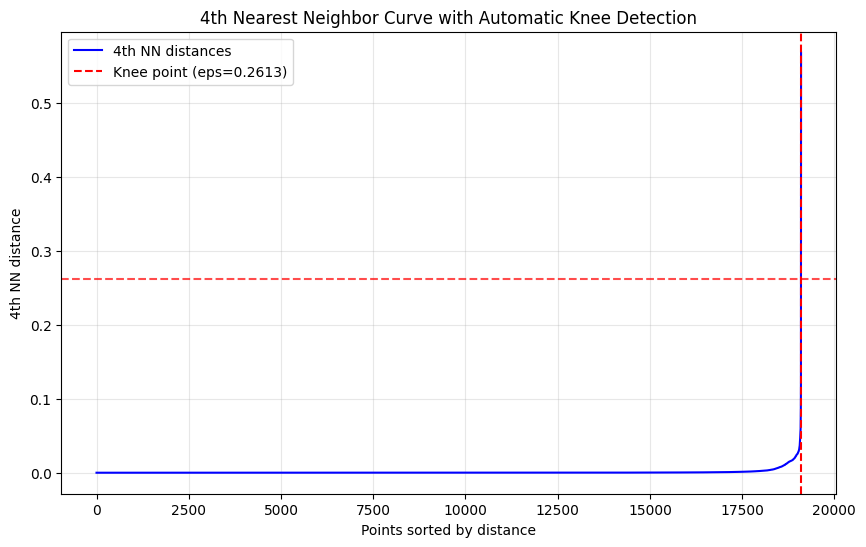

In [15]:
# Automatic knee detection for optimal eps value
try:
    from kneed import KneeLocator
    
    # Sort the distances for knee detection
    sorted_distances = sorted(fourth)
    x_values = range(len(sorted_distances))
    
    # Find the knee point
    knee_locator = KneeLocator(
        x_values, sorted_distances, 
        curve='convex', direction='increasing'
    )
    
    knee_point = knee_locator.knee
    if knee_point is not None:
        optimal_eps = sorted_distances[knee_point]
        print(f"Automatically detected optimal eps value: {optimal_eps:.4f}")
        print(f"Knee point located at index: {knee_point}")
        
        # Plot with knee point highlighted
        plt.figure(figsize=(10, 6))
        plt.plot(x_values, sorted_distances, 'b-', label='4th NN distances')
        plt.axvline(x=knee_point, color='r', linestyle='--', 
                   label=f'Knee point (eps={optimal_eps:.4f})')
        plt.axhline(y=optimal_eps, color='r', linestyle='--', alpha=0.7)
        plt.xlabel('Points sorted by distance')
        plt.ylabel('4th NN distance')
        plt.title('4th Nearest Neighbor Curve with Automatic Knee Detection')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No clear knee point detected. Consider manual inspection.")
        
except ImportError:
    print("kneed library not installed. Install with: pip install kneed")
    print("Falling back to manual inspection of the curve above.")

Use the knee point detected above to set your `eps` parameter, or manually inspect the curve to choose an appropriate value.

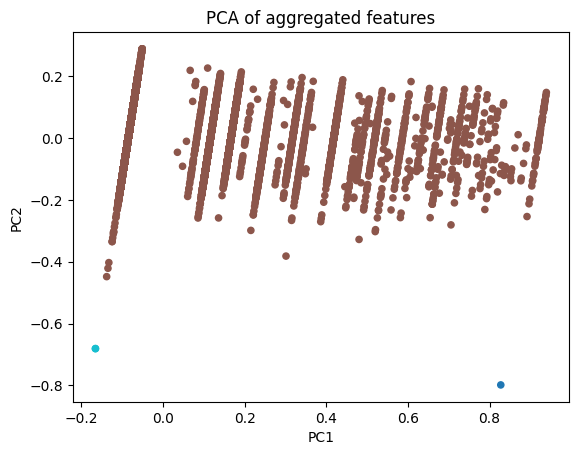

In [16]:
n_features = len(sim_cols)
n_components = min(2, n_features)
pca = PCA(n_components=n_components)
X = pca.fit_transform(agg[sim_cols])

plt.figure()
if n_components == 2:
    if 'cluster' in agg.columns:
        plt.scatter(X[:,0], X[:,1], c=agg['cluster'], cmap='tab10', s=20)
    else:
        plt.scatter(X[:,0], X[:,1], s=20)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
else:
    if 'cluster' in agg.columns:
        plt.scatter(X[:,0], [0]*len(X), c=agg['cluster'], cmap='tab10', s=20)
    else:
        plt.scatter(X[:,0], [0]*len(X), s=20)
    plt.xlabel('PC1')
    plt.ylabel('')
plt.title('PCA of aggregated features')
plt.show()

If cluster labels are provided, the scatter plot is coloured accordingly to inspect separability.

In [17]:
agg['cluster'].value_counts()


cluster
 0    19095
 1        2
-1        1
Name: count, dtype: int64

Display the number of records in each cluster to identify large or potentially problematic clusters.

In [18]:
big = agg[agg['cluster'] == 0]           # or whichever label is huge
big.head(20)                             # see company/domain/phone fields


,record_id,company_sim,domain_sim,cluster
0,7dfc4da6831e5ad058f18798beaad302,0.584425,0.000000,0
1,0ecd921b33e7d610a0c67c845d5c7b29,0.545891,0.000000,0
2,7cb3320183865e1058f18798beaad39a,0.556515,0.000000,0
3,8b559648334d96106049b4646d5c7b02,0.599583,0.000000,0
4,cd8b308c1b7380108321311d0d4bcbe0,0.881362,0.000000,0
5,387e521b8397129058f18798beaad3d9,0.360494,0.000000,0
6,211c68071be79510d1f74119b04bcbdb,0.692923,0.000000,0
7,649ab4841b7380108321311d0d4bcb1a,0.482407,0.000000,0
8,04ca3cc41b7380108321311d0d4bcb36,0.563194,0.000000,0
9,57b10e1787916550852d0e170cbb35f1,0.501389,0.000000,0


Inspect the records in the largest (or a selected) cluster to review company, domain, and phone fields for further analysis or manual investigation.